In [54]:
%pip install openpyxl
%pip  install seaborn
%pip install matplotlib
%pip install statsmodels
%pip install scikit-learn
import pandas as pd
import os
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [55]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [117]:
csv_path = "../data/processed/df_concat.csv"
csv_path = os.path.abspath(csv_path)

# Carregar os dados do CSV
df = pd.read_csv(csv_path)

df['DATA'] = pd.to_datetime(df['DATA'])
df['ANO'] = df['DATA'].dt.year
df['MES'] = df['DATA'].dt.month
df['DIA'] = df['DATA'].dt.day
df.drop(columns=['FILE_PATH', 'DOCUMENTO',], inplace=True)

df["TIPO_MOVIMENTO"] = df.apply(
    lambda row: "CRÉDITO" if row["CREDITO"] > 0 else ("DÉBITO" if row["DEBITO"] > 0 else "NENHUM"),
    axis=1
)

df

,DATA,DESCRICAO,CREDITO,DEBITO,SALDO,BANCO,CONTA,SUBCONTA,ANO,MES,DIA,TIPO_MOVIMENTO
0,2024-01-02,PAGAMENTO BOLETO PACKPAR EMBALAGENS,0.00,196.56,7087.8,INTER,Despesa com produtos,Materiais de Consumo,2024,1,2,DÉBITO
1,2024-01-02,PIX RECEBIDO CLEYTON GALEGO SOCIEDADE I. ADVOC...,3700.00,0.00,10787.8,INTER,Receita de vendas,Outras vendas,2024,1,2,CRÉDITO
2,2024-01-03,PIX RECEBIDO FERNANDA SARAIVA E SILVA,40.00,0.00,10827.8,INTER,Receita com serviços,Manutenção s/ Garantia,2024,1,3,CRÉDITO
3,2024-01-03,PIX RECEBIDO LEONARDO JOSE SIQUEIRA CASTILHOS,380.00,0.00,11207.8,INTER,Receita com serviços,Manutenção s/ Garantia,2024,1,3,CRÉDITO
4,2024-01-03,PIX ENVIADO GOVERNO DO PARANA SECRETARIA DE ES...,0.00,787.86,10419.94,INTER,Despesas tributárias,Outras,2024,1,3,DÉBITO
...,...,...,...,...,...,...,...,...,...,...,...,...
3573,2022-12-22,PAG FONE - NET FONE,0.00,123.56,"556,90",CAIXA,Despesas administrativas,"Telefonia (Celular, Fixo, Internet)",2022,12,22,DÉBITO
3574,2022-12-22,PAG FONE - CELULAR,0.00,57.61,"499,29",CAIXA,Despesas administrativas,"Telefonia (Celular, Fixo, Internet)",2022,12,22,DÉBITO
3575,2022-12-23,CRED TED - PAGSEGURO INTERNET LTDA,1660.47,0.00,"2.159,76",CAIXA,Receita com serviços,Outras,2022,12,23,CRÉDITO
3576,2022-12-23,CRED TED SPRINGER CARRIER LTDA NFS-e 2241,9310.87,0.00,"11.470,63",CAIXA,Receita com serviços,Spring,2022,12,23,CRÉDITO


In [118]:
df_saldo_ano = df.groupby('ANO').agg(
    TOTAL_CREDITO=('CREDITO', 'sum'),
    TOTAL_DEBITO=('DEBITO', 'sum')
)

df_saldo_ano['LUCRO_LIQUIDO'] = df_saldo_ano['TOTAL_CREDITO'] - df_saldo_ano['TOTAL_DEBITO']
df_saldo_ano

,TOTAL_CREDITO,TOTAL_DEBITO,LUCRO_LIQUIDO
ANO,,,
2022,543331.98,559898.01,-16566.03
2023,690034.98,680045.09,9989.89
2024,331238.94,342709.62,-11470.68


In [119]:
df_saldo_mes = df.groupby(['ANO', 'MES']).agg(
    TOTAL_CREDITO=('CREDITO', 'sum'),
    TOTAL_DEBITO=('DEBITO', 'sum')
)

# Calculando o lucro líquido mensal
df_saldo_mes['LUCRO_LIQUIDO'] = df_saldo_mes['TOTAL_CREDITO'] - df_saldo_mes['TOTAL_DEBITO']
df_saldo_mes

TOTAL_CREDITO  TOTAL_DEBITO  LUCRO_LIQUIDO
ANO  MES                                            
2022 1         36994.51      35093.80        1900.71
     2         46985.01      38372.54        8612.47
     3         50432.77      54035.86       -3603.09
     4         56811.26      40946.13       15865.13
     5         45184.27      41003.18        4181.09
     6         36756.62      51053.07      -14296.45
     7         67949.24      46910.14       21039.10
     8         54988.25      78746.14      -23757.89
     9         36668.44      42844.46       -6176.02
     10        35261.83      39203.97       -3942.14
     11        42732.85      41249.61        1483.24
     12        32566.93      50439.11      -17872.18
2023 1         37749.79      35157.12        2592.67
     2         34547.52      39236.52       -4689.00
     3         55974.44      44754.81       11219.63
     4         48356.78      39503.31        8853.47
     5         53943.53      41087.00       12856.53
     6         47744.72      41164.30        6580.42
     7         43858.77      57167.67      -13308.90
     8         41184.50      42638.60       -1454.10
     9         59029.84      56462.08        2567.76
     10       156667.84     177066.73      -20398.89
     11        44223.86      46506.42       -2282.56
     12        66753.39      59300.53        7452.86
2024 1         50087.54      49578.11         509.43
     2         35243.37      46825.17      -11581.80
     3         39846.19      41536.09       -1689.90
     4         48818.46      41682.93        7135.53
     5         58266.57      46460.95       11805.62
     6         38901.84      44213.97       -5312.13
     7         36635.31      42909.87       -6274.56
     8         23439.66      29502.53       -6062.87

In [120]:
df_saldo_mensal = df.groupby('MES').agg(
    TOTAL_CREDITO=('CREDITO', 'sum'),
    TOTAL_DEBITO=('DEBITO', 'sum')
)

# Calculando o lucro líquido por mês (somando diferentes anos)
df_saldo_mensal['LUCRO_LIQUIDO'] = df_saldo_mensal['TOTAL_CREDITO'] - df_saldo_mensal['TOTAL_DEBITO']
df_saldo_mensal

,TOTAL_CREDITO,TOTAL_DEBITO,LUCRO_LIQUIDO
MES,,,
1,124831.84,119829.03,5002.81
2,116775.90,124434.23,-7658.33
3,146253.40,140326.76,5926.64
4,153986.50,122132.37,31854.13
5,157394.37,128551.13,28843.24
6,123403.18,136431.34,-13028.16
7,148443.32,146987.68,1455.64
8,119612.41,150887.27,-31274.86
9,95698.28,99306.54,-3608.26


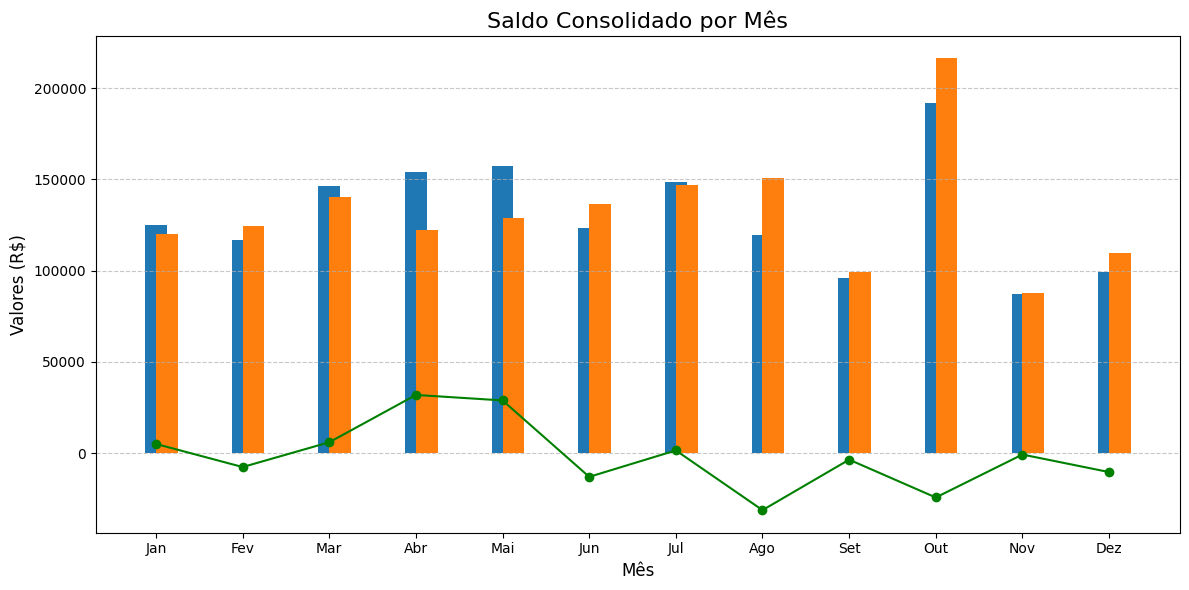

In [121]:
def plot_saldo_mensal(df_saldo_mensal):

    meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
    x = range(1, 13)  # Eixo X representando os meses
    
    plt.figure(figsize=(12, 6))
    plt.bar(x, df_saldo_mensal['TOTAL_CREDITO'], width=0.25, label='Total Crédito', align='center')
    plt.bar(x, df_saldo_mensal['TOTAL_DEBITO'], width=0.25, label='Total Débito', align='edge')
    plt.plot(x, df_saldo_mensal['LUCRO_LIQUIDO'], color='green', marker='o', label='Lucro Líquido')

    plt.title('Saldo Consolidado por Mês', fontsize=16)
    plt.xlabel('Mês', fontsize=12)
    plt.ylabel('Valores (R$)', fontsize=12)
    plt.xticks(x, meses)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_saldo_mensal(df_saldo_mensal)

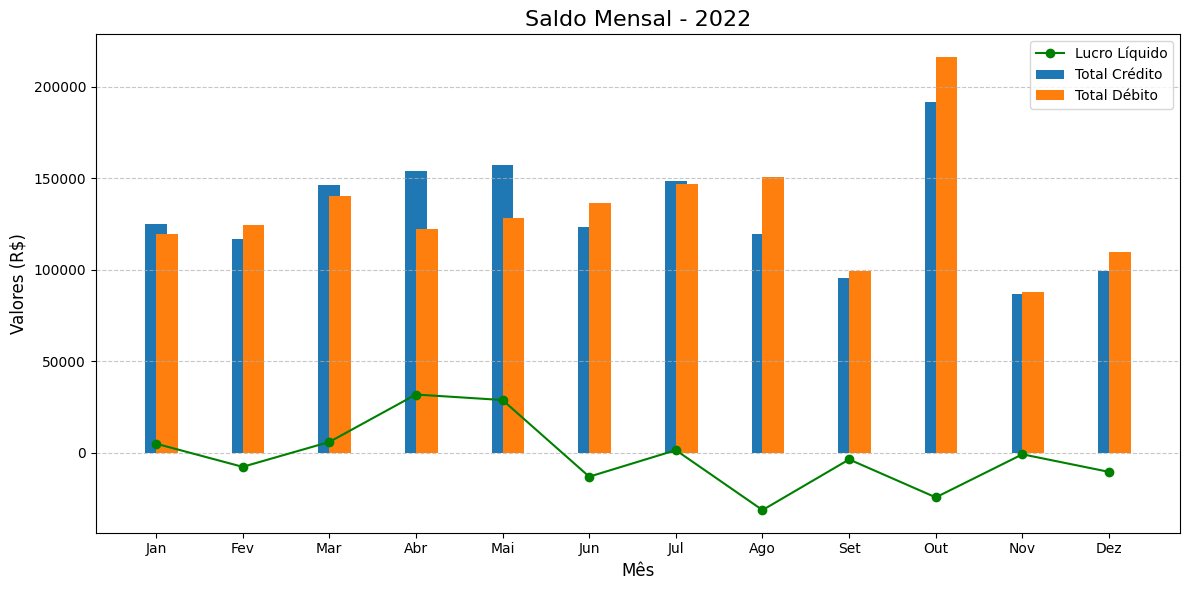

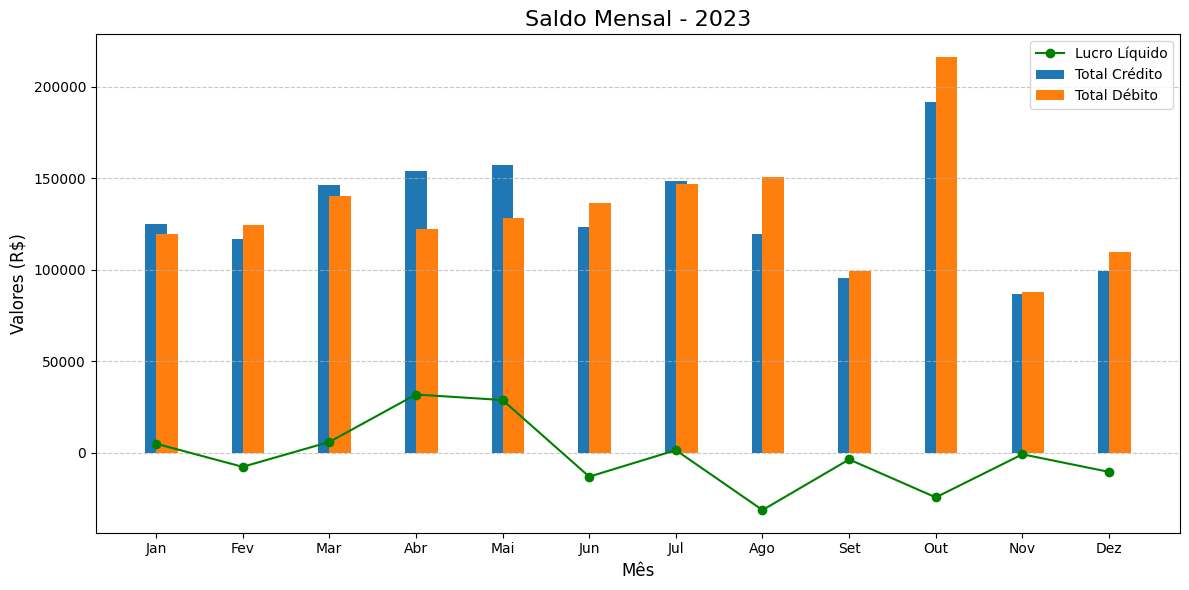

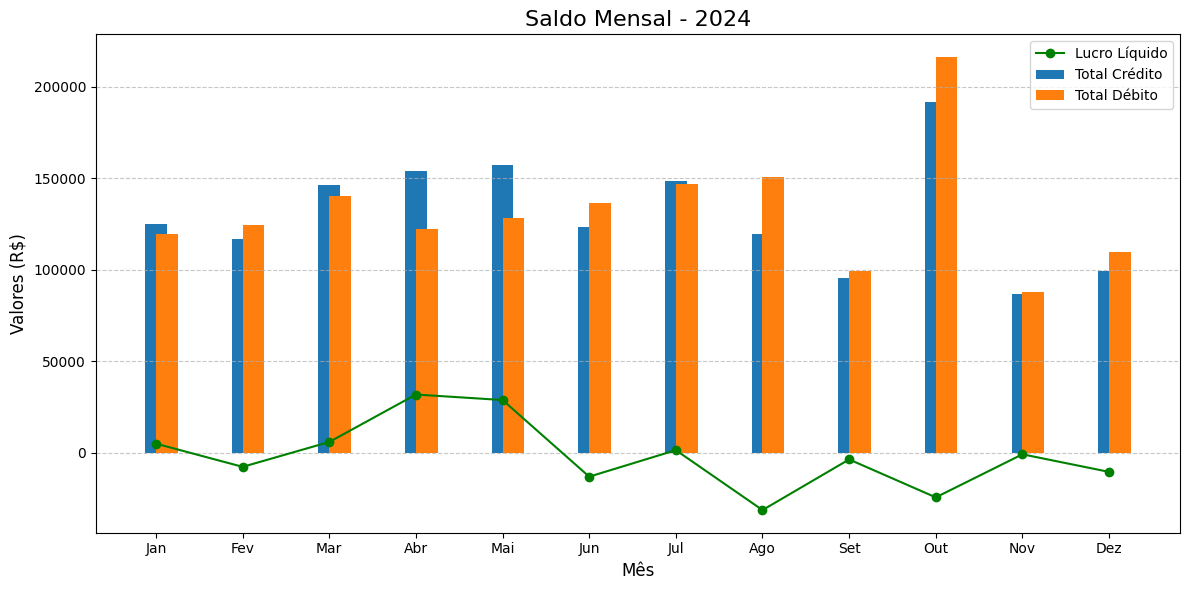

In [122]:

import matplotlib.pyplot as plt

def plot_saldo_mensal_por_ano(df_saldo_mes, ano):
    
    df_saldo_mes_reset = df_saldo_mes.reset_index()
    df_ano = df_saldo_mes_reset[df_saldo_mes_reset['ANO'] == ano]
    
    if df_ano.empty:
        print(f"Nenhum dado encontrado para o ano {ano}.")
        return

    meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
    x = range(1, 13)  # Eixo X representando os meses
    # Criando o gráfico
    plt.figure(figsize=(12, 6))
    plt.bar(x, df_saldo_mensal['TOTAL_CREDITO'], width=0.25, label='Total Crédito', align='center')
    plt.bar(x, df_saldo_mensal['TOTAL_DEBITO'], width=0.25, label='Total Débito', align='edge')
    plt.plot(x, df_saldo_mensal['LUCRO_LIQUIDO'], color='green', marker='o', label='Lucro Líquido')
    
    # Personalização
    plt.title(f'Saldo Mensal - {ano}', fontsize=16)
    plt.xlabel('Mês', fontsize=12)
    plt.ylabel('Valores (R$)', fontsize=12)
    plt.xticks(range(1, 13), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Exibir gráfico
    plt.tight_layout()
    plt.show()

# Exemplo de uso
anos =[ '2022', '2023', '2024']
for ano in anos:
    plot_saldo_mensal_por_ano(df_saldo_mes, int(ano))  

In [142]:
df_saldo_mensal

,TOTAL_CREDITO,TOTAL_DEBITO,LUCRO_LIQUIDO
MES,,,
1,124831.84,119829.03,5002.81
2,116775.90,124434.23,-7658.33
3,146253.40,140326.76,5926.64
4,153986.50,122132.37,31854.13
5,157394.37,128551.13,28843.24
6,123403.18,136431.34,-13028.16
7,148443.32,146987.68,1455.64
8,119612.41,150887.27,-31274.86
9,95698.28,99306.54,-3608.26


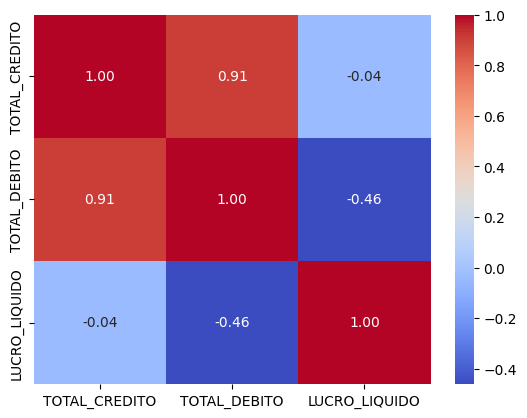

In [123]:
def plot_heatmap_correlacao(df):

    corr = df.corr()

    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
    plt.show()

plot_heatmap_correlacao(df_saldo_mes)


In [124]:
categorical_columns = ['BANCO','CONTA', 'SUBCONTA','TIPO_MOVIMENTO']  
df['SUBCONTA'] = df['SUBCONTA'].str.lower()

# Aplicando One-Hot Encoding a cada coluna da lista
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=False)
df_encoded.drop(columns=['DESCRICAO',], inplace=True)

# Exibindo o DataFrame resultante
print(df_encoded.head())

        DATA  CREDITO  DEBITO     SALDO   ANO  MES  DIA  BANCO_CAIXA  \
0 2024-01-02      0.0  196.56    7087.8  2024    1    2        False   
1 2024-01-02   3700.0    0.00   10787.8  2024    1    2        False   
2 2024-01-03     40.0    0.00   10827.8  2024    1    3        False   
3 2024-01-03    380.0    0.00   11207.8  2024    1    3        False   
4 2024-01-03      0.0  787.86  10419.94  2024    1    3        False   

   BANCO_CRED CREA  BANCO_INTER  ...  SUBCONTA_spring  \
0            False         True  ...            False   
1            False         True  ...            False   
2            False         True  ...            False   
3            False         True  ...            False   
4            False         True  ...            False   

   SUBCONTA_telefonia (celular, fixo, internet)  \
0                                         False   
1                                         False   
2                                         False   
3                   

In [125]:

headers = df_encoded.columns.tolist()

# Exibir os nomes das colunas
print(headers)

['DATA', 'CREDITO', 'DEBITO', 'SALDO', 'ANO', 'MES', 'DIA', 'BANCO_CAIXA', 'BANCO_CRED CREA', 'BANCO_INTER', 'CONTA_Despesa com pessoal', 'CONTA_Despesa com produtos', 'CONTA_Despesa com serviços', 'CONTA_Despesas administrativas', 'CONTA_Despesas financeiras', 'CONTA_Despesas tributárias ', 'CONTA_Outras Despesas ', 'CONTA_Outras entradas', 'CONTA_Receita com serviços', 'CONTA_Receita de vendas', 'CONTA_Receitas financeiras', 'CONTA_Transferência (Crédito)', 'CONTA_Transferência (Débito)', 'SUBCONTA_13º salário', 'SUBCONTA_alimentação (vr va)', 'SUBCONTA_aluguel imóvel', 'SUBCONTA_aplicação', 'SUBCONTA_assistência médica', 'SUBCONTA_aviso prévio / multa rescisória', 'SUBCONTA_bombeiros', 'SUBCONTA_cartório', 'SUBCONTA_ciee (estagiario)', 'SUBCONTA_combustivel', 'SUBCONTA_contabilidade', 'SUBCONTA_correios', 'SUBCONTA_despesas bancárias', 'SUBCONTA_despesas com cobrança', 'SUBCONTA_elgin', 'SUBCONTA_emprestimo', 'SUBCONTA_empréstimo contratado', 'SUBCONTA_energia', 'SUBCONTA_estorno de

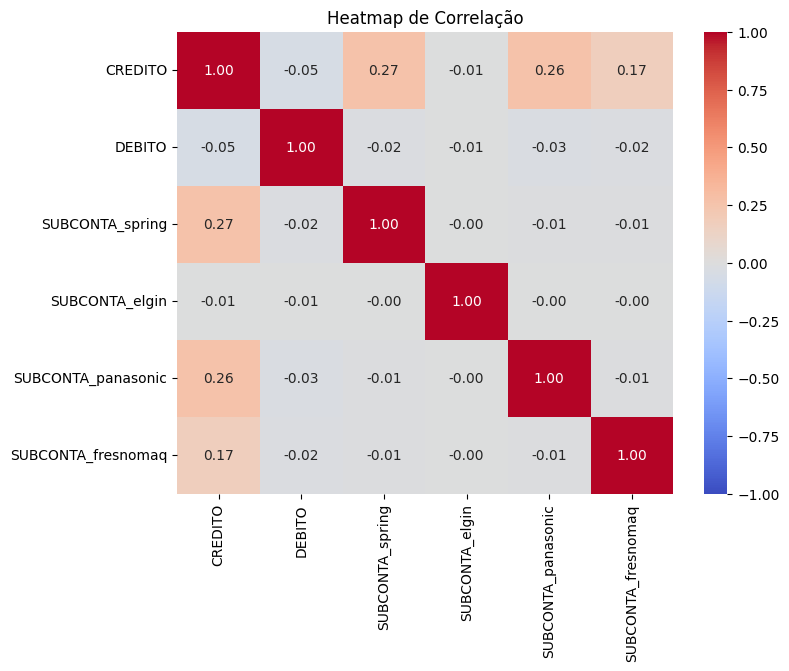

In [130]:

numerical_cols = df_encoded[['CREDITO', 'DEBITO',  'SUBCONTA_spring','SUBCONTA_elgin', 'SUBCONTA_panasonic', 'SUBCONTA_fresnomaq']]

# Calcular a matriz de correlação
corr_matrix = numerical_cols.corr()

# Criar o heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Heatmap de Correlação")
plt.show()

In [144]:
df['ANO_MES'] = df['DATA'].dt.strftime('%y-%m')
df_credito_mes  = df.groupby('ANO_MES').agg(total_credito = ('CREDITO',sum),
                             total_debito = ('DEBITO', sum))
df_credito_mes['LiQUIDO'] = df_credito_mes['total_credito'] - df_credito_mes['total_debito'] 
df_credito_mes

C:\Users\criis\AppData\Local\Temp\ipykernel_18168\3984597976.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_credito_mes  = df.groupby('ANO_MES').agg(total_credito = ('CREDITO',sum),
C:\Users\criis\AppData\Local\Temp\ipykernel_18168\3984597976.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_credito_mes  = df.groupby('ANO_MES').agg(total_credito = ('CREDITO',sum),


,total_credito,total_debito,LiQUIDO
ANO_MES,,,
22-01,36994.51,35093.80,1900.71
22-02,46985.01,38372.54,8612.47
22-03,50432.77,54035.86,-3603.09
22-04,56811.26,40946.13,15865.13
22-05,45184.27,41003.18,4181.09
22-06,36756.62,51053.07,-14296.45
22-07,67949.24,46910.14,21039.10
22-08,54988.25,78746.14,-23757.89
22-09,36668.44,42844.46,-6176.02


In [154]:
time_series = df_saldo_mensal
nome_coluna = 'TOTAL_CREDITO'

def test_stationarity(series):
    result = adfuller(series)
    print("Teste de Dickey-Fuller Aumentado:")
    print(f"Estatística de Teste: {result[0]:.4f}")
    print(f"Valor-p: {result[1]:.4f}")
    print(f"Valores Críticos:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")
    return result[1]

def transform_to_stationary_series(time_series, column=nome_coluna):

  p_value = test_stationarity(time_series[column])
  print(f"Valor-p do teste de estacionariedade: {p_value}")
  if p_value > 0.05:
      time_series['Data_diff'] = time_series[column].diff()
      series_to_analyze = time_series['Data_diff'].dropna()
      print("A série não é estacionária. Aplicando diferenciação.")
  else:
      series_to_analyze = time_series[column]
      print("A série é estacionária. Não é necessário diferenciação.")
  return series_to_analyze

def obtain_autocorreletion_partial_autocorrelation_parameters(series_to_analyze):
  # 2. Identificar os parâmetros (p, d, q) e (P, D, Q, m)
  acf_values = acf(series_to_analyze, nlags=3)
  pacf_values = pacf(series_to_analyze, nlags=3)
  return acf_values, pacf_values

def plot_acf(acf_values):
  # Plot ACF
  plt.figure(figsize=(10, 4))
  plt.stem(range(len(acf_values)), acf_values)
  plt.title("ACF (Autocorrelação) - Série Estacionária", fontsize=14)
  plt.xlabel("Lags", fontsize=12)
  plt.ylabel("Autocorrelação", fontsize=12)
  plt.grid()
  plt.show()

def plot_pacf(pacf_values):
  # Plot PACF
  plt.figure(figsize=(10, 4))
  plt.stem(range(len(pacf_values)), pacf_values)
  plt.title("PACF (Autocorrelação Parcial) - Série Estacionária", fontsize=14)
  plt.xlabel("Lags", fontsize=12)
  plt.ylabel("Autocorrelação Parcial", fontsize=12)
  plt.grid()
  plt.show()

def train_sarima_model(series_to_analyze:None|pd.DataFrame=None,
                       train_data=None, test_data=None):
  if train_data == None or test_data == None:
    # 3. Treinar o modelo SARIMA (usando valores arbitrários para p, d, q, P, D, Q, m)
    p, d, q = 1, 1, 1  # Componentes regulares
    P, D, Q, m = 1, 1, 1, 12  # Componentes sazonais, com sazonalidade de 12
    train_data = series_to_analyze[:-3]  # Últimos 10 valores como teste
    test_data = series_to_analyze[-3:]

  model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, m))
  model_fit = model.fit(disp=False)
  print(model_fit.summary())
  return model_fit, train_data, test_data


def eval_model(model_fit, train_data, test_data):
  # 4. Avaliar o desempenho
  predictions = model_fit.forecast(steps=3)
  mae = mean_absolute_error(test_data, predictions)
  mse = mean_squared_error(test_data, predictions)

  print("\nAvaliação do Modelo SARIMA:")
  print(f"Erro Absoluto Médio (MAE): {mae:.4f}")
  print(f"Erro Médio Quadrático (MSE): {mse:.4f}")

  # Gráfico da série temporal predita
  plt.figure(figsize=(12, 6))
  plt.plot(range(len(train_data)), train_data, label="Treino", color="blue")
  plt.plot(range(len(train_data), len(train_data) + len(test_data)), test_data, label="Teste", color="orange")
  plt.plot(range(len(train_data), len(train_data) + len(predictions)), predictions, label="Previsões", color="green", linestyle="--")
  plt.title("Série Temporal Predita com SARIMA", fontsize=14)
  plt.xlabel("Tempo", fontsize=12)
  plt.ylabel("Valor", fontsize=12)
  plt.legend(fontsize=10)
  plt.grid(alpha=0.5)
  plt.show()

Teste de Dickey-Fuller Aumentado:
Estatística de Teste: -9.8172
Valor-p: 0.0000
Valores Críticos:
   1%: -4.9387
   5%: -3.4776
   10%: -2.8439
Valor-p do teste de estacionariedade: 5.457773752028443e-17
A série é estacionária. Não é necessário diferenciação.


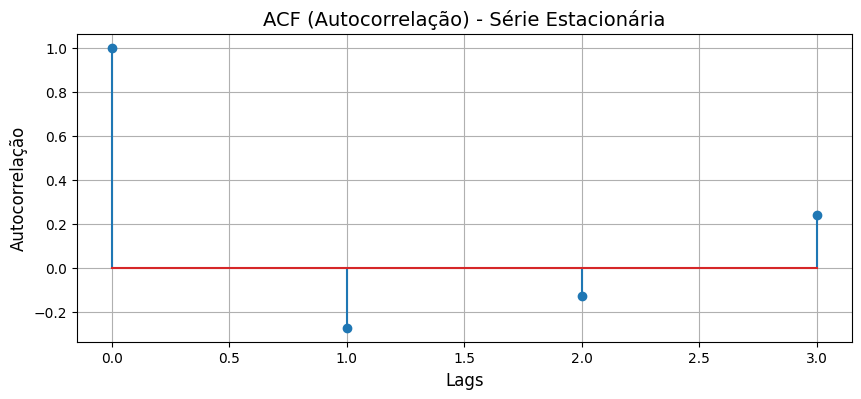

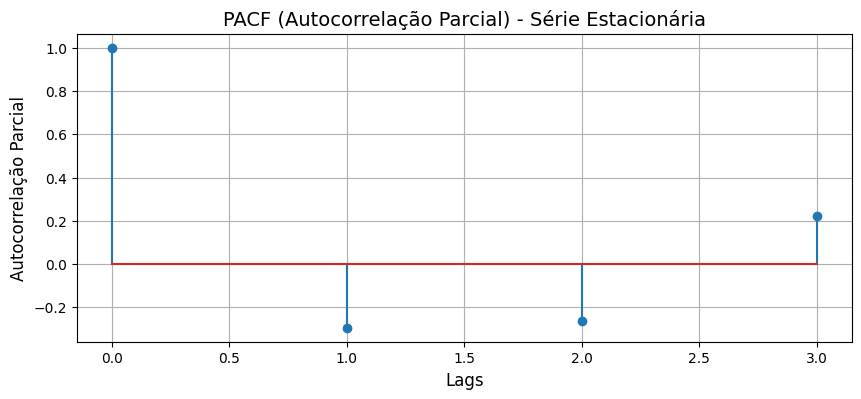

                                     SARIMAX Results                                      
Dep. Variable:                      TOTAL_CREDITO   No. Observations:                    9
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   0.000
Date:                            Thu, 28 Nov 2024   AIC                             10.000
Time:                                    20:17:53   BIC                                nan
Sample:                                         0   HQIC                               nan
                                              - 9                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1               0         -0        nan        nan           0           0
ma.L1               0         -0   

d:\VScodeWorkspace\proj5\plurii-eceel\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\VScodeWorkspace\proj5\plurii-eceel\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\VScodeWorkspace\proj5\plurii-eceel\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
d:\VScodeWorkspace\proj5\plurii-eceel\.venv\Lib\site-packages\statsmodels\tsa\st

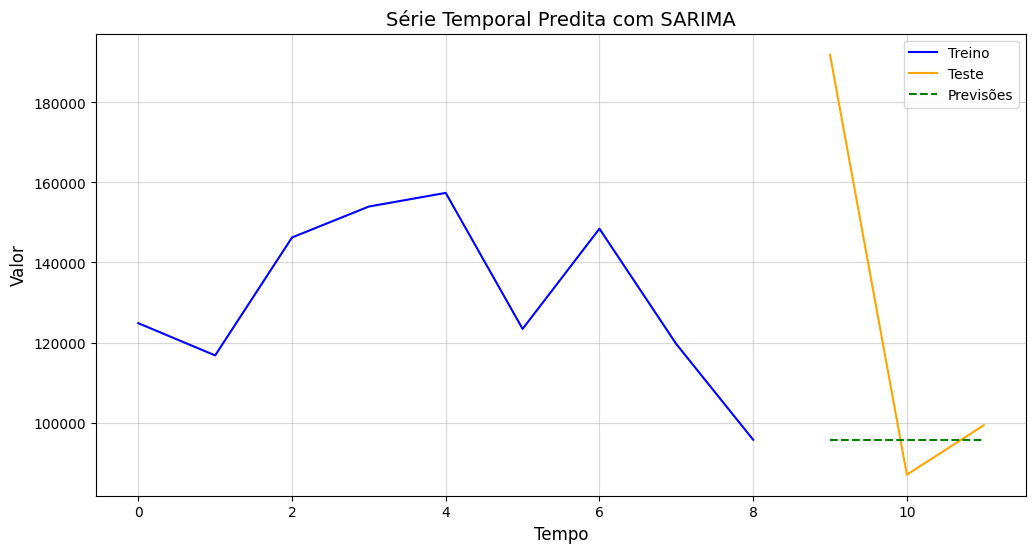

In [155]:
series_to_analyze = transform_to_stationary_series(time_series, column=nome_coluna)

acf_values, pacf_values = obtain_autocorreletion_partial_autocorrelation_parameters(series_to_analyze)
plot_acf(acf_values)
plot_pacf(pacf_values)

model_fit, train_data, test_data = train_sarima_model(series_to_analyze=series_to_analyze)

eval_model(model_fit, train_data, test_data)